In [ ]:
# ============================================================
#  Trapped Ion Qunantum Physics — Ponderomotive Force
# ------------------------------------------------------------
#  Author: Gabriele Johannes Giuli
#  Email: ggiuli@ethz.ch
#  Institution: ETH Zürich
#  Description: Simulation of the time-varying quadrupole
#               potential in a RF Paul trap
#  Created: 2025-10-22
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from sympy.vector import CoordSys3D, gradient
from matplotlib.animation import FuncAnimation
from scipy.integrate import odeint

# Trapping an Ion
Let's see if we can trap an ion with static fields only. 
To this end, let's consider the electric potential, defined as
$$
\vec{E} = -\nabla\varphi.
$$

We now consider Maxwell's equation for the divergence of the electric field, in the absence of charges, namely
$$
\nabla \cdot \vec{E} = 0,
$$
and we substitute for $\vec{E}$. Therefore we obtain
$$
\nabla \cdot (-\nabla\varphi) = \nabla^2\varphi = 0.
$$
If we were to expand the laplacian of the electric potential, we would find the following form:
$$
\frac{\partial^2\varphi}{\partial x^2} + \frac{\partial^2\varphi}{\partial y^2} + \frac{\partial^2\varphi}{\partial z^2} = 0.
$$
Therefore, we see that the curvature (and thereofore the confinement) of the potential cannot be of the same sign in the three spatial directions. Therefore, if we want to confine our particle - therefore wanting all three second derivatives to be greeater than zero, we would not be able to do so with a static field.

## Paul Trap
One way to get around this limitation is to use the *Paul Trap* architecture. In a Paul (or RF) trap we confine the ions in the axial direction with a simple quadratic potential given by a capacitor, namely
$$
\varphi_\mathrm{axial}(z) = \varphi_{0,z} z^2.
$$
Since we are not able to confine in all three directions, the best we can do is to create a quadrupole potential in the radial direction
$$
\varphi_\mathrm{radial}(x, y) = \varphi_{0,r} (x^2 - y^2).
$$
Note that the total potential seen by the ion will be given by
$$
\varphi(x,y,z) = \varphi_\mathrm{axial}(z) + \varphi_\mathrm{radia}(x, y).
$$
Since we established that we will be able to trap in the axial direction, let us concentrate on the radial motion. The first thing that we do is to find the field components: 

In [2]:
phi_0, phi = sp.symbols('phi_0 phi')
N = CoordSys3D('N')

phi = phi_0*(N.x**2 - N.y**2)
E = -gradient(phi)

potential_2d = sp.lambdify([N.x, N.y, phi_0], phi, 'numpy')
field_2d_x = sp.lambdify([N.x, N.y, phi_0], E.dot(N.i))
field_2d_y = sp.lambdify([N.x, N.y, phi_0], E.dot(N.j))

E

(-2*N.x*phi_0)*N.i + 2*N.y*phi_0*N.j

We also plot the potential in the radial directions. We expect to see a saddle!

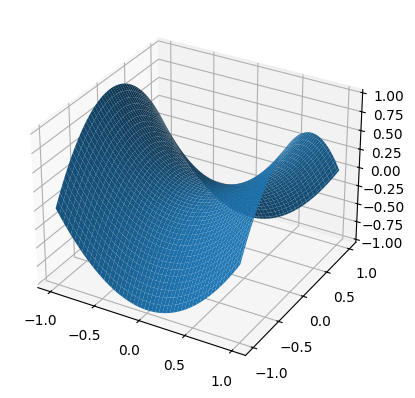

In [3]:
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
x_mesh, y_mesh = np.meshgrid(x, y)

phi_mesh = potential_2d(x_mesh, y_mesh, 1)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x_mesh, y_mesh, phi_mesh)

We can also plot the resulting field, and thus force imparted from the ion. On the same plot we will show the potential as a colour plot, and the field as a quiver plot.

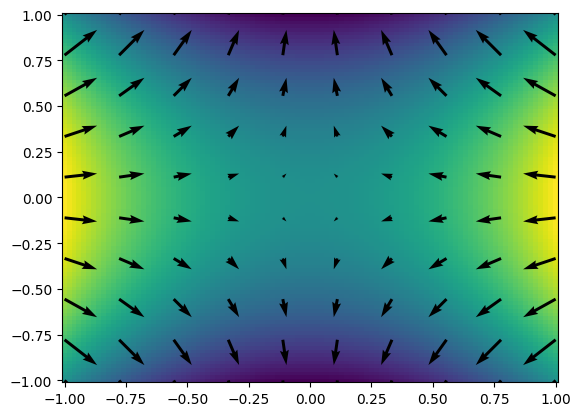

In [4]:
plt.figure()

x = np.linspace(-1, 1, 10)
y = np.linspace(-1, 1, 10)
x_mesh_q, y_mesh_q = np.meshgrid(x, y)

field_x_mesh = field_2d_x(x_mesh_q, y_mesh_q, 1)
field_y_mesh = field_2d_y(x_mesh_q, y_mesh_q, 1)

plt.pcolor(x_mesh, y_mesh, phi_mesh)
plt.quiver(x_mesh_q, y_mesh_q, field_x_mesh, field_y_mesh)

All is looking nice and colorful, but we still have the issue that our static traps only confines along $z$ and $x$. This can be seen by the convergence of the field-lines along the $x$-direction and the divergence along the $y$-direction.

The key to solving this issue is to quickly switching confinement and anti-confinement among the two radial directions. In this way, the radial potential becomes
$$
\varphi_\mathrm{radial}(x, y, t) = \varphi_{0,r} \cos(\omega_\text{RF}t)(x^2 - y^2).
$$


In [5]:
theta = sp.symbols('theta')
phi_t = phi.subs(phi_0, sp.cos(theta))
E_t = -gradient(phi_t)

potential_2d_t = sp.lambdify([N.x, N.y, theta], phi_t)
field_2d_x_t = sp.lambdify([N.x, N.y, theta], E_t.dot(N.i))
field_2d_y_t = sp.lambdify([N.x, N.y, theta], E_t.dot(N.j))

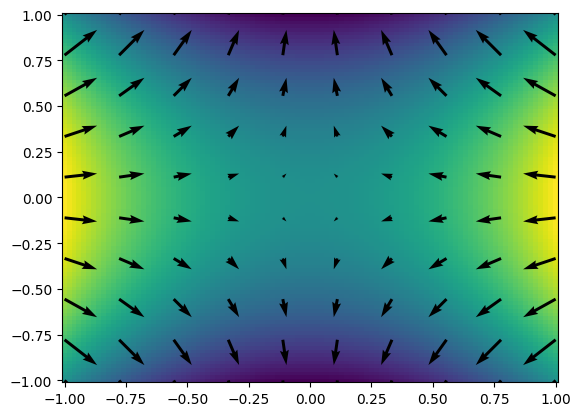

In [6]:
tot_frames = 100

phi_mesh = potential_2d_t(x_mesh, y_mesh, 0)
field_x_mesh = field_2d_x_t(x_mesh_q, y_mesh_q, 0)
field_y_mesh = field_2d_y_t(x_mesh_q, y_mesh_q, 0)

fig, ax = plt.subplots()
pcolor_plot = plt.pcolor(x_mesh, y_mesh, phi_mesh)
quiver = plt.quiver(x_mesh_q, y_mesh_q, field_x_mesh, field_y_mesh)

def update(frame):
    theta = (2*np.pi/tot_frames) * (frame + 1)

    phi_mesh = potential_2d_t(x_mesh, y_mesh, theta)
    field_x_mesh = field_2d_x_t(x_mesh_q, y_mesh_q, theta)
    field_y_mesh = field_2d_y_t(x_mesh_q, y_mesh_q, theta)
    
    pcolor_plot.set_array(phi_mesh.flatten())
    quiver.set_UVC(field_x_mesh, field_y_mesh)
    
    return pcolor_plot,

ani = FuncAnimation(fig, update, frames=np.arange(0, tot_frames), blit=True)
ani.save('../output/vector_field_animation.gif', writer='pillow', fps=15)

Look how the confinement and anti-confinement are swapped as time passes by. As long as you create the correct folder, you can save the animation gif in case you have the irresistible urge to share this with your friends.

## Adding the Ion
Let us now solve for the motion of the ion. It should be somewhat intuitive that, as ling as $\omega_\text{RF}$ is fast enough when compared with the ion's dynamics, we should be able to trap the ion. Let's see the movement of the ion in the Paul trap. Here we will plot its $x$ and $y$ coordinate as time passes by.

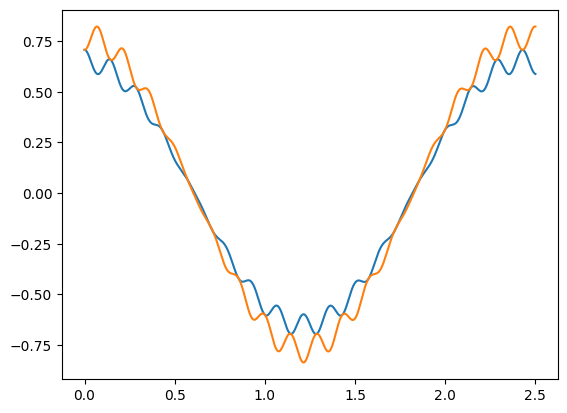

In [7]:
def model(state, t, f, qm):
    omega = 2*np.pi*f
    theta = omega*t

    x, y, dx, dy = state
    ddx = qm*field_2d_x_t(x, y, theta)
    ddy = qm*field_2d_y_t(x, y, theta)

    return [dx, dy, ddx, ddy]

f = 7
qm = 80

t = np.linspace(0, 2.5, 30000)
ic = [0.707, 0.707, 0, 0]
sol1 = odeint(model, ic, t, args=(f, qm))
ic = [0, 0.8, 0, 0]
sol2 = odeint(model, ic, t, args=(f, qm))

x = sol1[:, 0]
y = sol1[:, 1]

x2 = sol2[:, 0]
y2 = sol2[:, 1]

plt.figure()
plt.plot(t, x)
plt.plot(t, y)

You see that we have two types of motion:
1. The slow-frequency oscillations are called the _secular_ motion;
2. while the low-amplitude and high-frequency oscillations are called _micromotion_ and are due to the RF drive.
Note that micromotion is often unwanted. Now  let's try to visualize what is going on in a single plot.

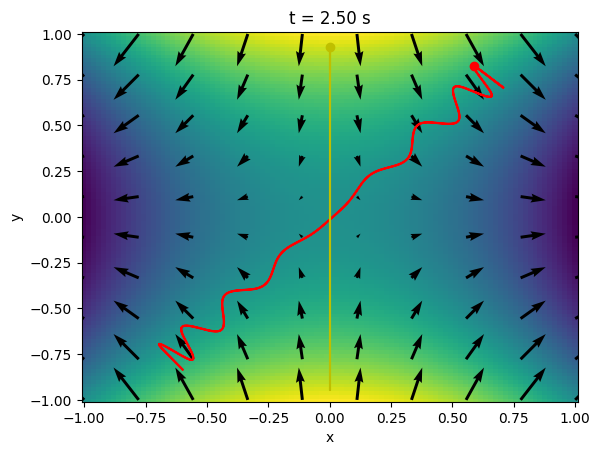

In [8]:
downsample_factor = 30

time_downsampled = t[::downsample_factor]
x_p_downsampled = x[::downsample_factor]
y_p_downsampled = y[::downsample_factor]

x_p_downsampled2 = x2[::downsample_factor]
y_p_downsampled2 = y2[::downsample_factor]

phi_mesh = potential_2d_t(x_mesh, y_mesh, 0)
field_x_mesh = field_2d_x_t(x_mesh_q, y_mesh_q, 0)
field_y_mesh = field_2d_y_t(x_mesh_q, y_mesh_q, 0)

fig, ax = plt.subplots()
pcolor_plot = plt.pcolor(x_mesh, y_mesh, phi_mesh)
quiver = plt.quiver(x_mesh_q, y_mesh_q, field_x_mesh, field_y_mesh)

point, = plt.plot(x_p_downsampled[0], y_p_downsampled[0], 'ro', label='marker only')
trace, = plt.plot([], [], 'r-')

point2, = plt.plot(x_p_downsampled2[0], y_p_downsampled2[0], 'yo', label='marker only')
trace2, = plt.plot([], [], 'y-')

ax.set_xlabel('x')
ax.set_ylabel('y')

def update(frame):
    ax.set_title(f't = {time_downsampled[frame]:.2f} s')
    theta = time_downsampled[frame]*2*np.pi*f

    phi_mesh = potential_2d_t(x_mesh, y_mesh, theta)
    field_x_mesh = field_2d_x_t(x_mesh_q, y_mesh_q, theta)
    field_y_mesh = field_2d_y_t(x_mesh_q, y_mesh_q, theta)

    sub_x = x_p_downsampled[0:frame]
    sub_y = y_p_downsampled[0:frame]

    sub_x2 = x_p_downsampled2[0:frame]
    sub_y2 = y_p_downsampled2[0:frame]
    
    pcolor_plot.set_array(phi_mesh.flatten())
    quiver.set_UVC(field_x_mesh, field_y_mesh)

    point.set_data([x_p_downsampled[frame]], [y_p_downsampled[frame]])
    trace.set_data(sub_x, sub_y)

    point2.set_data([x_p_downsampled2[frame]], [y_p_downsampled2[frame]])
    trace2.set_data(sub_x2, sub_y2)

    return pcolor_plot,

ani = FuncAnimation(fig, update, frames=np.arange(0, len(time_downsampled)), blit=True)
ani.save('../output/particle_motion.gif', writer='pillow', fps=15)

Have a look how important micormotion is to the "formation" of the pseudopotential. Keep an eye on the two particles and see how the probing of the field due to micromotion ensures that the two particles exhibit the same secular motion.

Now try to change the parameters until you cannot trap anymore.